In [1]:
# Installing collected packages

#!pip install duckdb
#!pip install python-dotenv

In [2]:
# Libraries

import requests
import pandas as pd
import numpy as np
import os
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Setting pandas to display all columns and rows
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


# Load API key from .env file
load_dotenv('.env')
api_key = os.getenv('API_KEY')

C:\Users\lokadmin\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def extract(api_key):
    """
    Fetch and process air quality measurements from the OpenAQ API.

    Parameters
    ----------
    api_key : str
        API key for authentication with the OpenAQ API.

    Returns
    -------
    df : pandas.DataFrame
        Dataframe containing the fetched measurements.
        
    Raises
    ------
    requests.exceptions.HTTPError
        For HTTP related errors.
    requests.exceptions.ConnectionError
        For connection related errors.
    requests.exceptions.Timeout
        For timeout errors.
    requests.exceptions.RequestException
        For all other request related errors.
    Exception
        If the fetched dataframe is empty.

    """
    
    # API URL
    api_url = "https://api.openaq.org/v2/measurements"
    
    # Define the query parameters to API
    params = {
        "location_id": "380422",
        "parameter": ["pressure", "temperature", "humidity", "wind_speed", "wind_direction", "pm1", "pm10", "pm25", "O3", "co", "nox", "so2","um003", "um005", "um010", "um025", "um050", "um100"],
        "limit": 50000,
        "api_key": api_key
    }
    
    try:
        # Make the GET request
        response = requests.get(api_url, params=params)
        
        # Raise exception for HTTP errors
        response.raise_for_status()
        
        # Check if the request was successful
        if response.status_code == 200:
            data = response.json()
            output = pd.json_normalize(data['results'])
            df = pd.DataFrame(output)
            
            # Check if dataframe is empty
            if df.empty:
                raise Exception("Empty df, check API request")
            
            df['date.utc'] = pd.to_datetime(df['date.utc'], errors='coerce') # Convert to datetime
            df['date.local'] = df['date.utc'].dt.tz_convert('America/Los_Angeles') # Covert to PST/PDT time zone
            df['date.local'] = df['date.local'].dt.tz_localize(None) # Convert to timezone-naive
            df = df[df['value'] > 0.0] # Filter values
            
            return df
        
    except requests.exceptions.HTTPError as errh:
        print("Http Error:", errh)
    except requests.exceptions.ConnectionError as errc:
        print("Error Connecting:", errc)
    except requests.exceptions.Timeout as errt:
        print("Timeout Error:", errt)
    except requests.exceptions.RequestException as err:
        print("Error: Something Else", err)
    except Exception as e:
        print(e)

In [4]:
# Call extract function
df = extract(api_key)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35037 entries, 0 to 40055
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   locationId             35037 non-null  int64              
 1   location               35037 non-null  object             
 2   parameter              35037 non-null  object             
 3   value                  35037 non-null  float64            
 4   unit                   35037 non-null  object             
 5   country                35037 non-null  object             
 6   city                   0 non-null      object             
 7   isMobile               35037 non-null  bool               
 8   isAnalysis             0 non-null      object             
 9   entity                 35037 non-null  object             
 10  sensorType             35037 non-null  object             
 11  date.utc               35037 non-null  datetime64[ns, 

## Available Parameters

In [6]:
# Get locations from API

endpoint = "https://api.openaq.org/v2/parameters"

params = {
    "limit": 1000,
    "api_key": "bca2413f10b586fc8e29e6a7712258baf2d528cfdfc06dcba5bf1cc44e714a9c"
}

# API request
response = requests.get(endpoint, params=params)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    data = response.json()
    output = data['results']
    parameters = pd.DataFrame(output)
else:
    print("Error:", response.status_code)


print(parameters.info())

parameters

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             64 non-null     int64 
 1   name           64 non-null     object
 2   displayName    60 non-null     object
 3   description    64 non-null     object
 4   preferredUnit  64 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.6+ KB
None


,id,name,displayName,description,preferredUnit
0,1,pm10,PM10,Particulate matter less than 10 micrometers in...,µg/m³
1,2,pm25,PM2.5,Particulate matter less than 2.5 micrometers i...,µg/m³
2,3,o3,O₃ mass,Ozone mass concentration,µg/m³
3,4,co,CO mass,Carbon Monoxide mass concentration,µg/m³
4,5,no2,NO₂ mass,Nitrogen Dioxide mass concentration,µg/m³
5,6,so2,SO₂ mass,Sulfur Dioxide mass concentration,µg/m³
6,7,no2,NO₂,Nitrogen Dioxide concentration,ppm
7,8,co,CO,Carbon Monoxide concentration,ppm
8,9,so2,SO₂,Sulfur Dioxide concentration,ppm
9,10,o3,O₃,Ozone concentration,ppm


# EDA

In [7]:
# Dataframe with downloaded data
df.head(20)

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
0,380422,Tipperary Park,pm10,29.333333,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
1,380422,Tipperary Park,humidity,70.033333,%,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
2,380422,Tipperary Park,um005,8.706667,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
3,380422,Tipperary Park,um010,1.790000,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
4,380422,Tipperary Park,um050,0.012667,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
5,380422,Tipperary Park,pm25,27.296667,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
6,380422,Tipperary Park,pressure,1009.865000,mb,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
7,380422,Tipperary Park,um003,29.451333,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
8,380422,Tipperary Park,temperature,62.933333,f,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
9,380422,Tipperary Park,um025,0.121333,particles/cm³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118


In [8]:
# Number of columns in the dataframe
df.columns

Index(['locationId', 'location', 'parameter', 'value', 'unit', 'country',
       'city', 'isMobile', 'isAnalysis', 'entity', 'sensorType', 'date.utc',
       'date.local', 'coordinates.latitude', 'coordinates.longitude'],
      dtype='object')

In [9]:
# Data types per column in the dataframe
df.dtypes

locationId                             int64
location                              object
parameter                             object
value                                float64
unit                                  object
country                               object
city                                  object
isMobile                                bool
isAnalysis                            object
entity                                object
sensorType                            object
date.utc                 datetime64[ns, UTC]
date.local                    datetime64[ns]
coordinates.latitude                 float64
coordinates.longitude                float64
dtype: object

In [10]:
# Number of unique variables in the column 'parameter'
df['parameter'].unique()

array(['pm10', 'humidity', 'um005', 'um010', 'um050', 'pm25', 'pressure',
       'um003', 'temperature', 'um025', 'um100', 'pm1'], dtype=object)

In [11]:
# Number of observations for parameter 'pm25'
df[df["parameter"] == "pm25"].size

62490

In [12]:
# Dataframe filtered by parameter 'pm25'
df[df["parameter"] == "pm25"].head()

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,date.local,coordinates.latitude,coordinates.longitude
5,380422,Tipperary Park,pm25,27.296667,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 10:00:00+00:00,2023-10-20 03:00:00,49.208733,-122.9118
12,380422,Tipperary Park,pm25,28.003333,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 09:00:00+00:00,2023-10-20 02:00:00,49.208733,-122.9118
33,380422,Tipperary Park,pm25,20.486667,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 08:00:00+00:00,2023-10-20 01:00:00,49.208733,-122.9118
41,380422,Tipperary Park,pm25,17.010345,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 07:00:00+00:00,2023-10-20 00:00:00,49.208733,-122.9118
54,380422,Tipperary Park,pm25,14.586667,µg/m³,CA,None,False,None,Community Organization,low-cost sensor,2023-10-20 06:00:00+00:00,2023-10-19 23:00:00,49.208733,-122.9118


In [13]:
# Value of parameter 'pm25' in the first 5 lines of the filtered dataframe 
df['value'][df["parameter"] == "pm25"].head()

5     27.296667
12    28.003333
33    20.486667
41    17.010345
54    14.586667
Name: value, dtype: float64

In [14]:
# Basic statistics for parameter 'pm25'
df['value'][df["parameter"] == "pm25"].describe()

count    4166.000000
mean        9.373384
std        10.274498
min         0.014286
25%         2.760385
50%         5.949000
75%        11.681319
max       116.162069
Name: value, dtype: float64

In [15]:
# Basic statistics for all variables in column 'parameter' + number of NaN values
for par in df['parameter'].unique():
    result = df['value'][df["parameter"] == par].describe()
    nan_values = df['value'][df["parameter"] == par].isna().sum()
    print(par, end='\n')
    print (result)
    print('Number of nan values:', nan_values)
    print('\n')

pm10
count    4166.000000
mean       10.283100
std        11.859655
min         0.052381
25%         3.030208
50%         6.387213
75%        12.461936
max       124.034483
Name: value, dtype: float64
Number of nan values: 0


humidity
count    2510.000000
mean       50.132394
std        13.213358
min        16.857143
25%        39.957288
50%        50.677083
75%        61.777778
max        81.739130
Name: value, dtype: float64
Number of nan values: 0


um005
count    2510.000000
mean        4.112273
std         4.469625
min         0.237143
25%         1.622814
50%         2.738929
75%         4.756578
max        53.062414
Name: value, dtype: float64
Number of nan values: 0


um010
count    4166.000000
mean        0.598788
std         0.822167
min         0.007083
25%         0.168974
50%         0.331237
75%         0.679365
max        11.748276
Name: value, dtype: float64
Number of nan values: 0


um050
count    1153.000000
mean        0.007930
std         0.013112
min         0.000

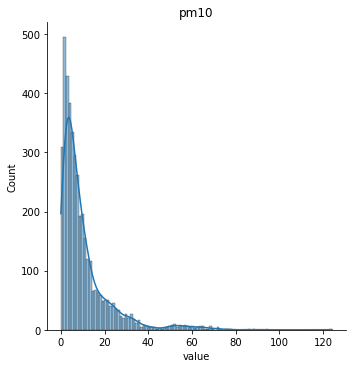

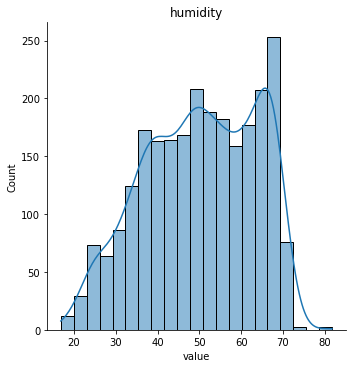

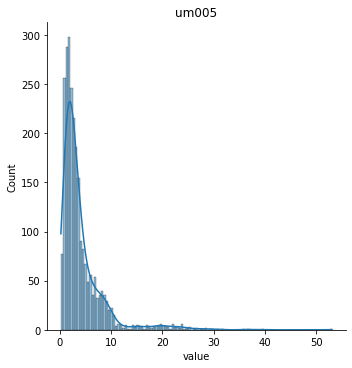

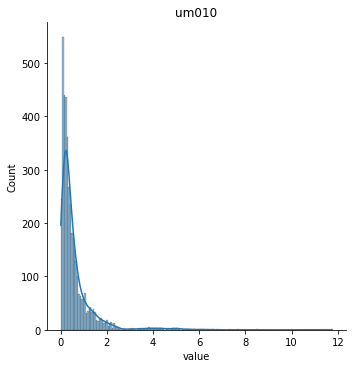

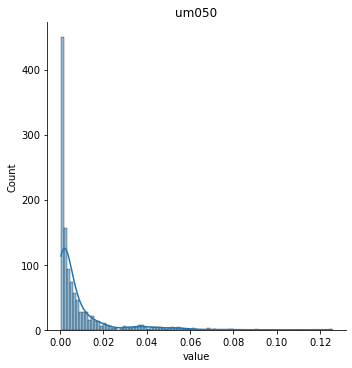

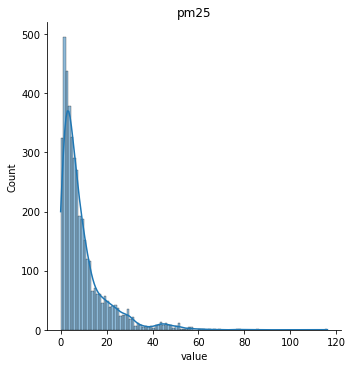

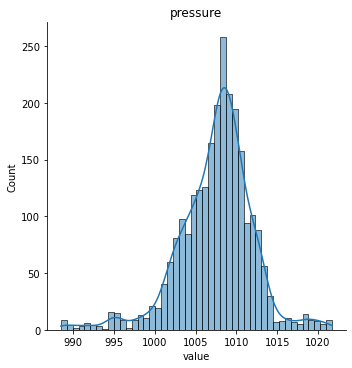

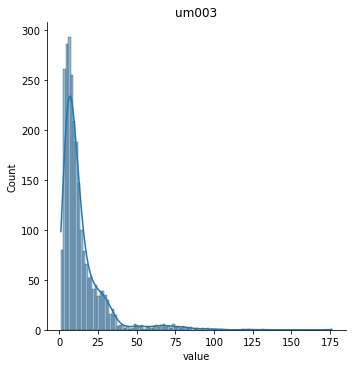

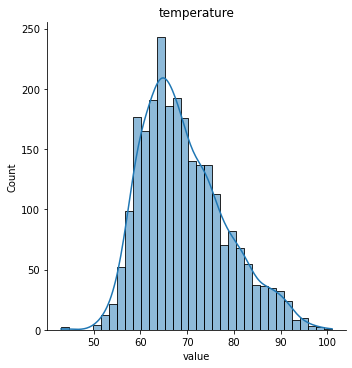

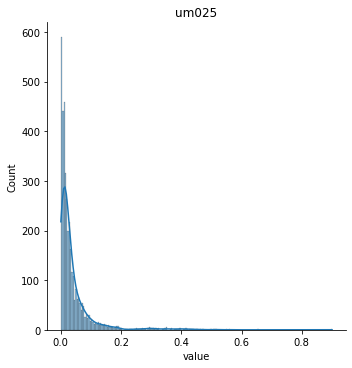

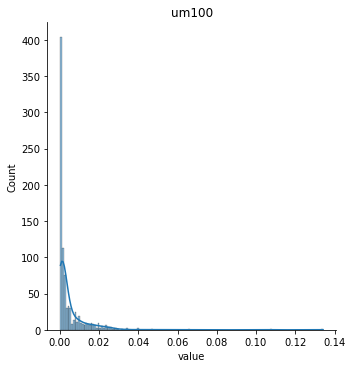

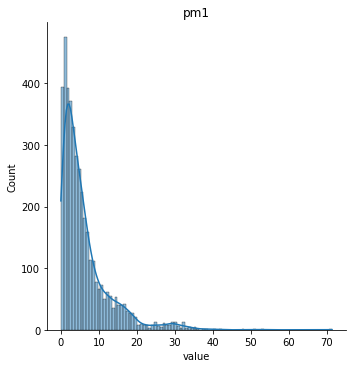

In [16]:
# Distribution plot for all variables in column 'parameter'
for par in df['parameter'].unique():
    sns.displot(df['value'][df["parameter"] == par], kde=True).set(title=par)

In [17]:
# Beginning and end of the time series
print(df['date.local'].min())
print(df['date.local'].max())

2022-11-20 17:00:00
2023-10-20 03:00:00


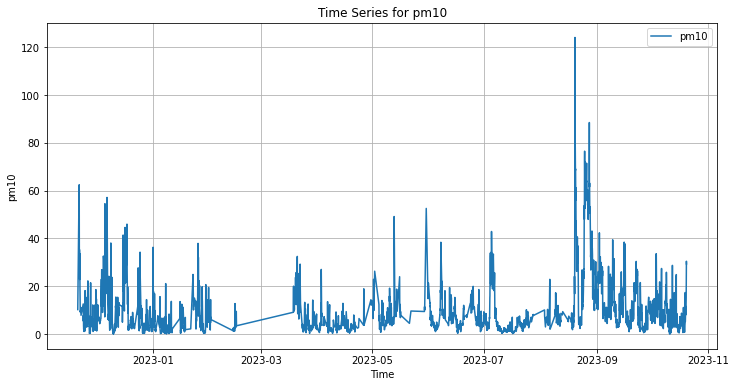

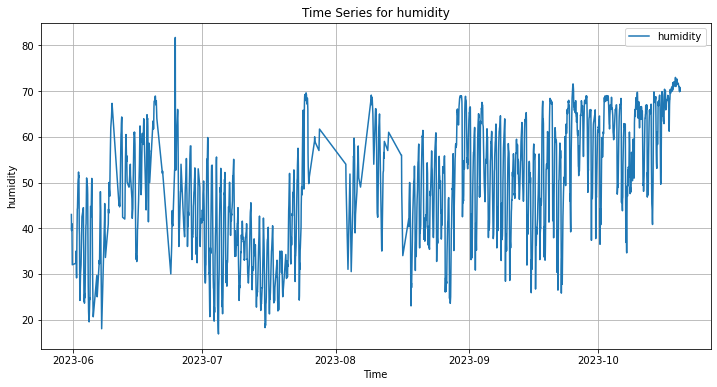

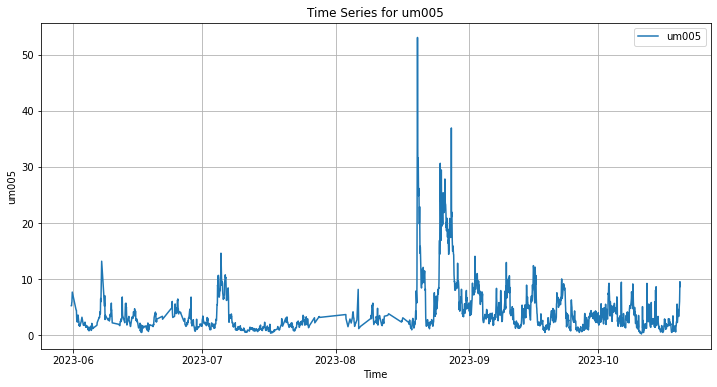

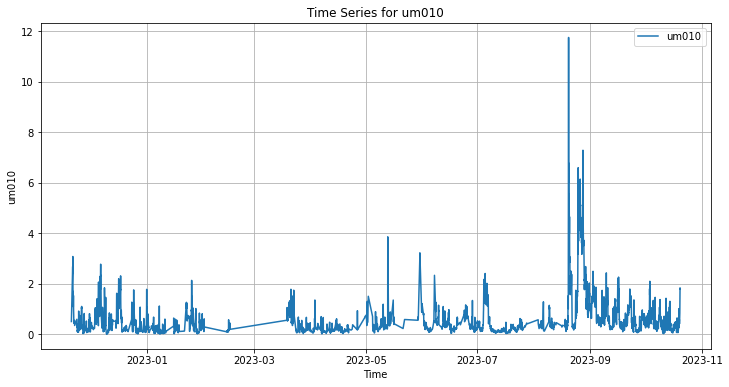

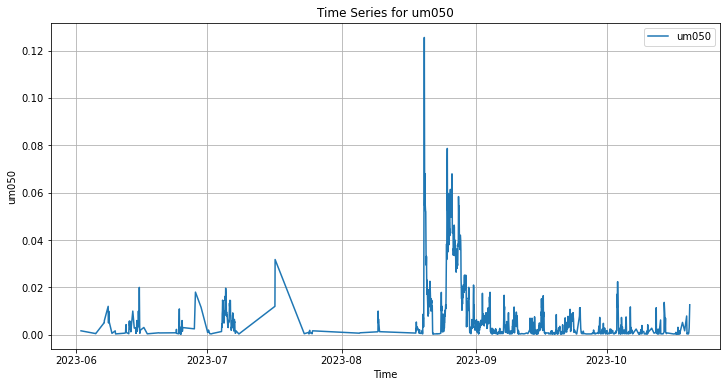

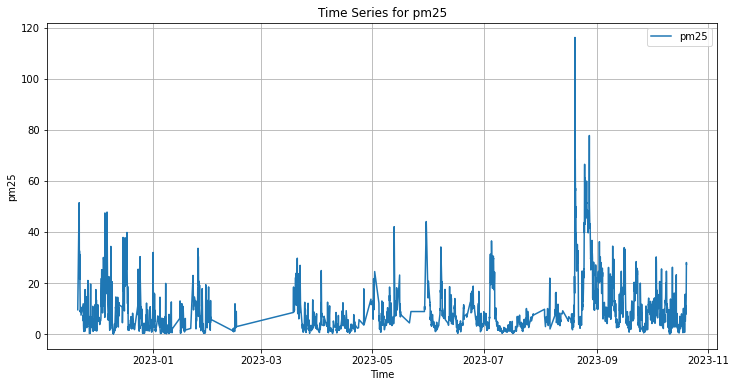

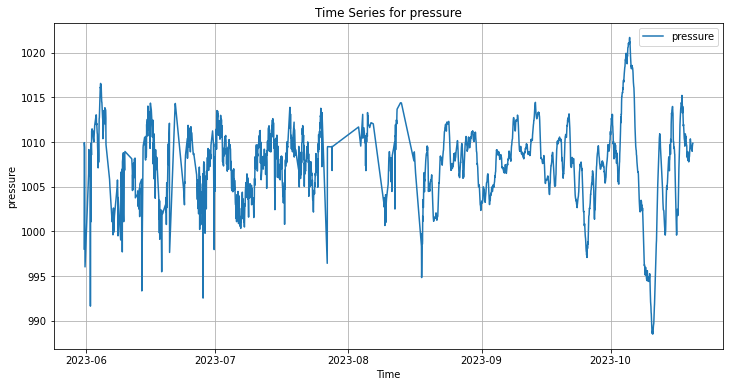

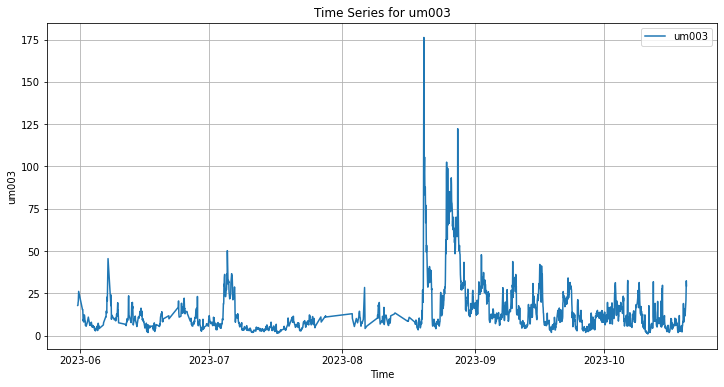

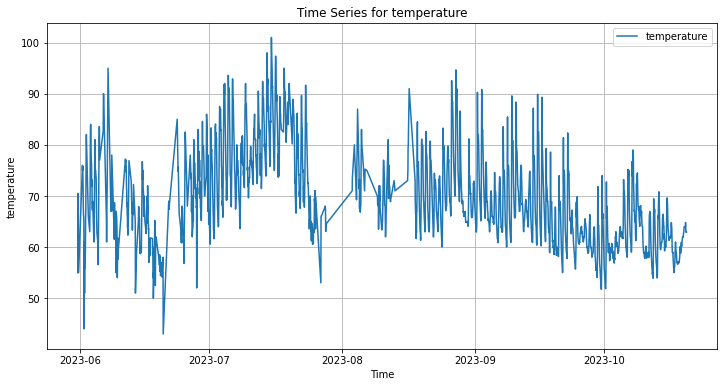

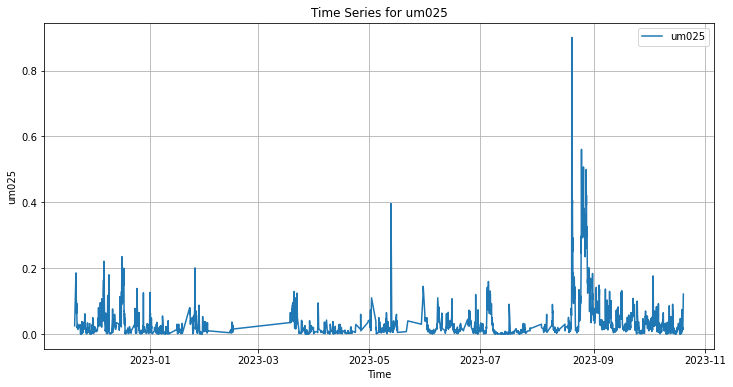

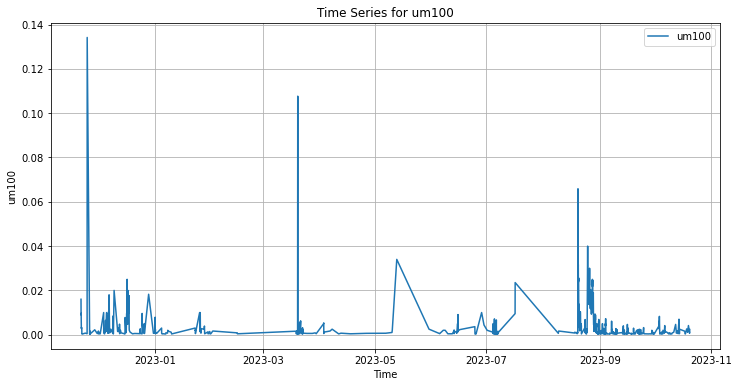

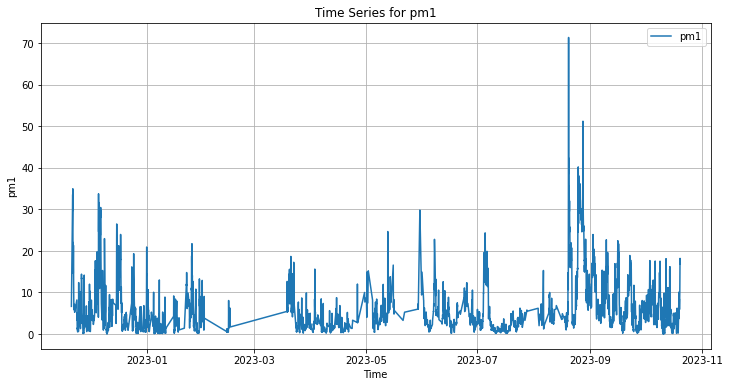

In [18]:
# Time series for each variable

# Loop through unique parameters
for par in df['parameter'].unique():
    plt.figure(figsize=(12, 6))
    
    # Filter the dataFrame for the current parameter
    subset = df[df['parameter'] == par]
    
    # Create the plot
    plt.plot(subset['date.local'], subset['value'], label=par)
    
    plt.xlabel('Time')
    plt.ylabel(par)
    plt.grid(True)
    plt.legend()
    plt.title(f"Time Series for {par}")
    plt.show()

In [19]:
#for parameter in df['parameter'].unique():
#    locals()[parameter] = df[df["parameter"] == parameter]
    
#pm25.head()

In [20]:
# Pivot table with columns for each variable
pivoted_df = df.pivot_table(index=df['date.local'], columns='parameter', values='value')
pivoted_df.head(20)

parameter,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100
date.local,,,,,,,,,,,,
2022-11-20 17:00:00,NaN,6.650000,10.250000,9.500000,NaN,NaN,NaN,NaN,0.500000,0.025000,NaN,NaN
2022-11-21 10:00:00,NaN,33.600000,60.220000,50.420000,NaN,NaN,NaN,NaN,2.678000,0.184000,NaN,0.016000
2022-11-21 11:00:00,NaN,29.728571,51.614286,44.053571,NaN,NaN,NaN,NaN,2.401786,0.157500,NaN,0.008929
2022-11-21 12:00:00,NaN,34.979310,62.441379,51.451724,NaN,NaN,NaN,NaN,3.074483,0.185517,NaN,0.009655
2022-11-21 13:00:00,NaN,28.222222,48.892593,41.762963,NaN,NaN,NaN,NaN,2.449630,0.154444,NaN,0.009630
2022-11-21 14:00:00,NaN,18.152174,28.652174,26.921739,NaN,NaN,NaN,NaN,1.408261,0.087391,NaN,0.003478
2022-11-21 15:00:00,NaN,22.044828,35.382759,32.610345,NaN,NaN,NaN,NaN,1.694138,0.103793,NaN,0.002759
2022-11-21 16:00:00,NaN,21.570000,34.316667,31.843333,NaN,NaN,NaN,NaN,1.615333,0.100333,NaN,0.003333
2022-11-21 17:00:00,NaN,21.300000,33.803704,31.318519,NaN,NaN,NaN,NaN,1.594444,0.100000,NaN,0.003333


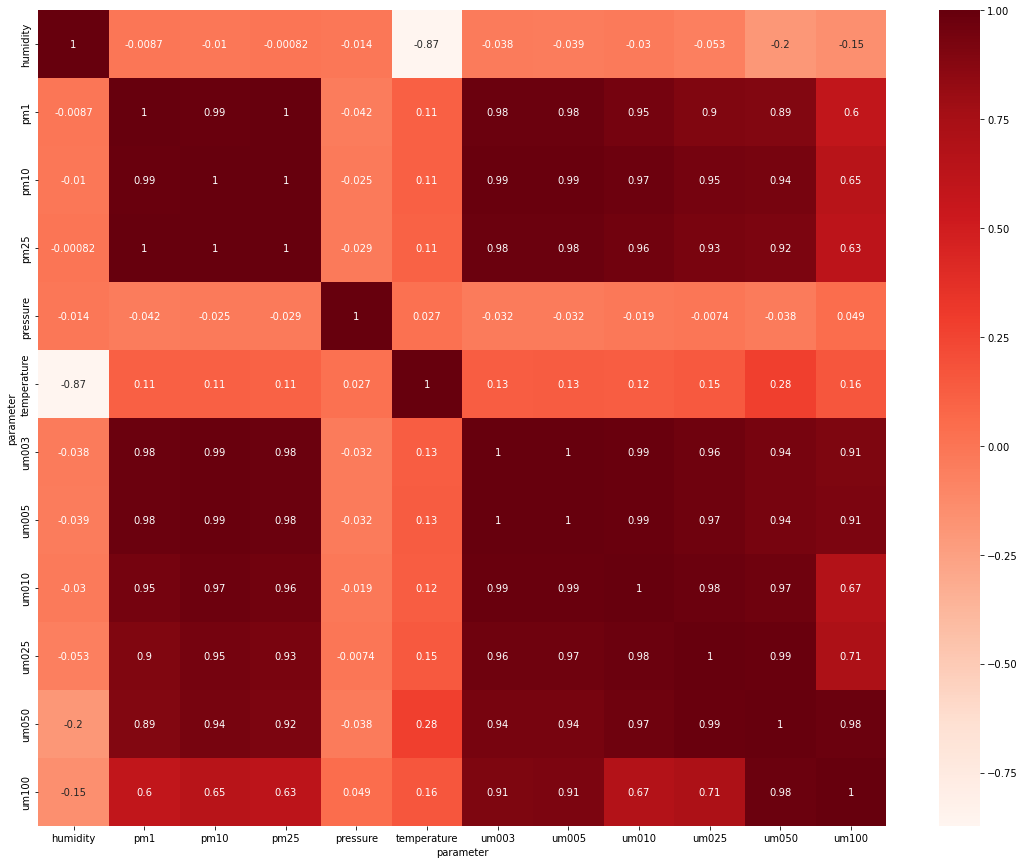

In [21]:
# Correlation matrix
corr_matrix = pivoted_df.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

In [22]:
# Daily mean
df_mean = df.groupby(['parameter', df['date.local'].dt.date])['value'].mean().reset_index()
df_mean

,parameter,date.local,value
0,humidity,2023-05-31,39.300000
1,humidity,2023-06-01,36.266001
2,humidity,2023-06-02,42.620567
3,humidity,2023-06-03,31.911368
4,humidity,2023-06-04,33.633567
5,humidity,2023-06-05,39.248077
6,humidity,2023-06-06,26.888889
7,humidity,2023-06-07,37.693802
8,humidity,2023-06-08,39.600000
9,humidity,2023-06-09,52.874837


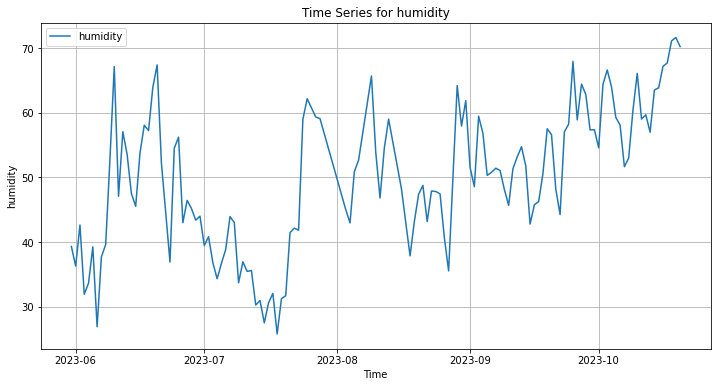

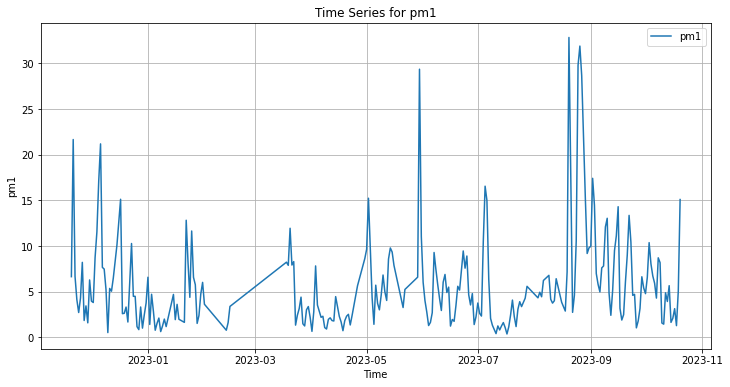

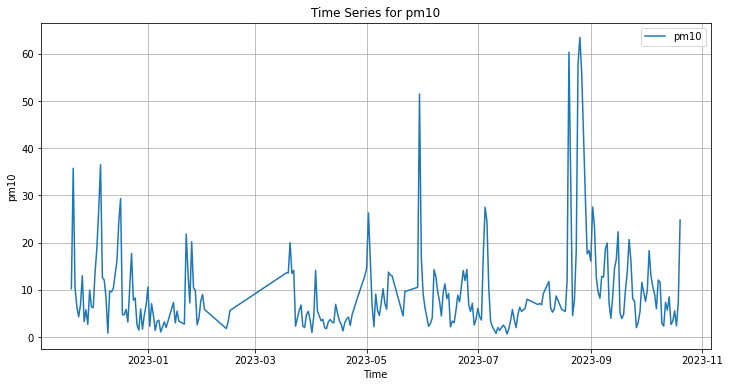

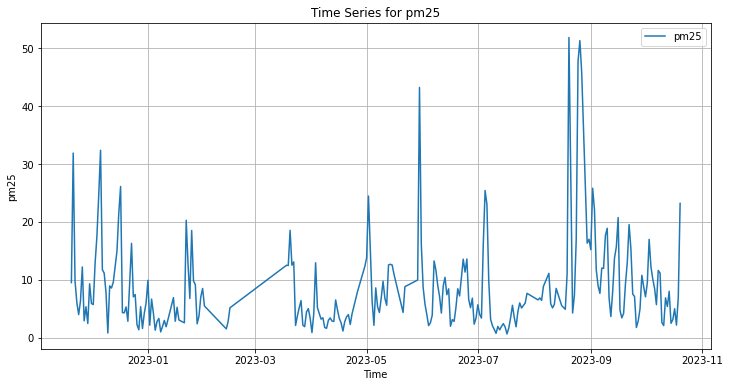

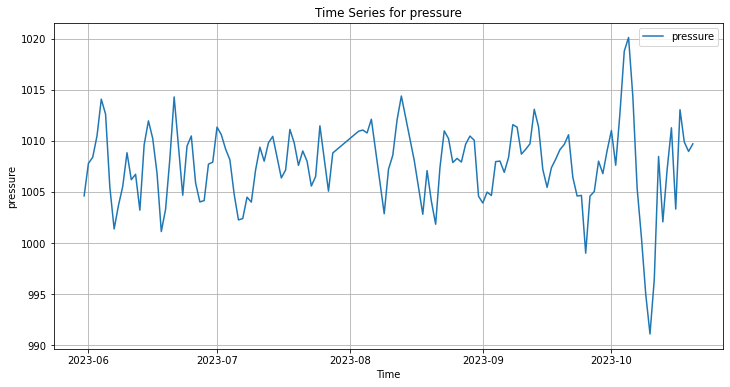

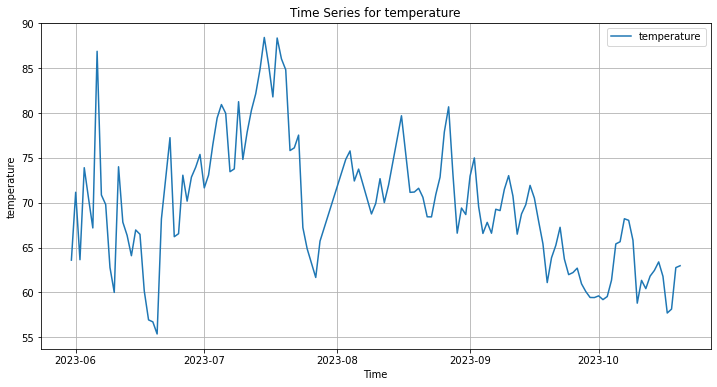

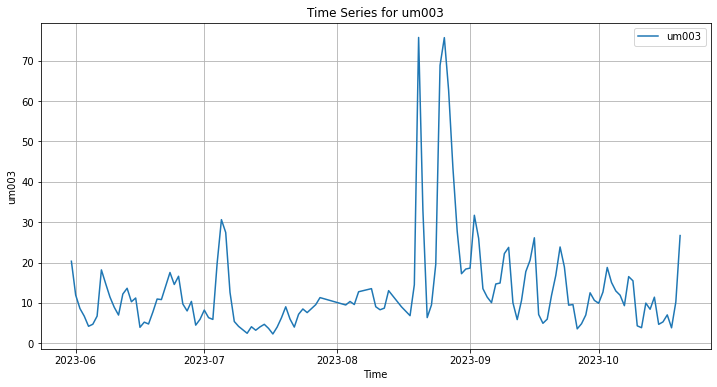

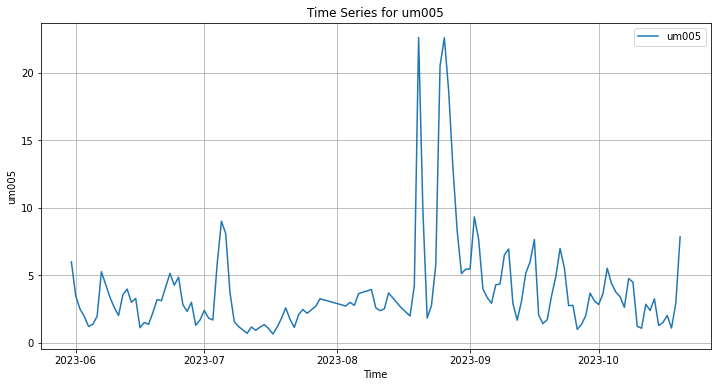

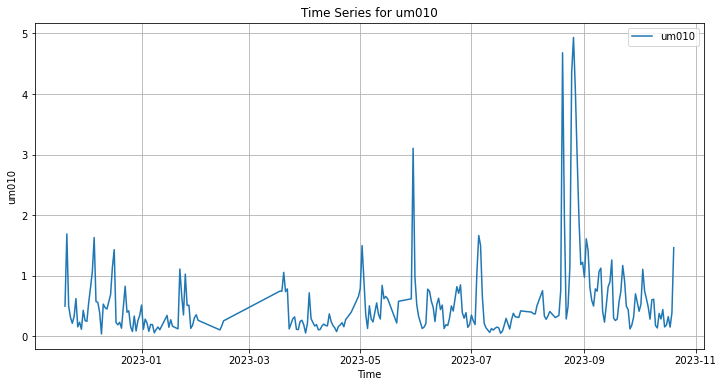

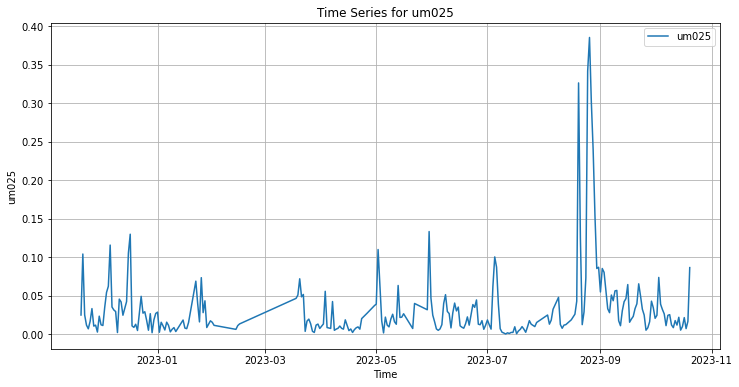

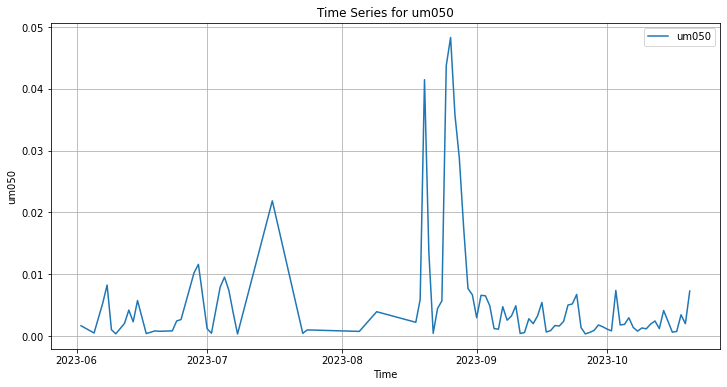

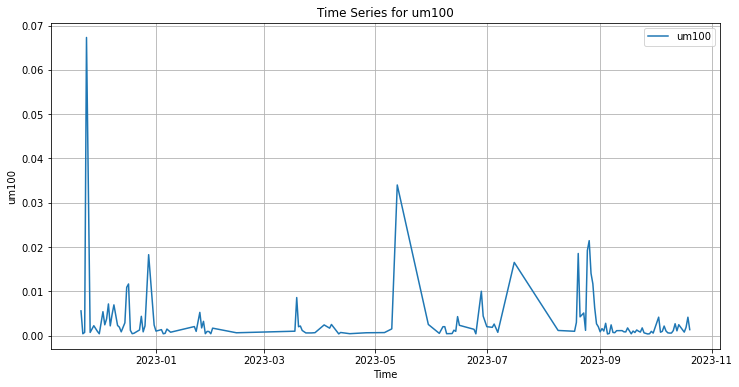

In [23]:
# Time series on a daily scale for each variable

# Loop through unique parameters
for par in df_mean['parameter'].unique():
    plt.figure(figsize=(12, 6))
    
    # Filter the dataFrame for the current parameter
    subset = df_mean[df_mean['parameter'] == par]
    
    # Create the plot
    plt.plot(subset['date.local'], subset['value'], label=par)
    
    plt.xlabel('Time')
    plt.ylabel(par)
    plt.grid(True)
    plt.legend()
    plt.title(f"Time Series for {par}")
    plt.show()

# Air Quality Index (AIQ)

In [24]:
# Pivot table with daily means per variable
df_mean_day = df_mean.pivot_table(index=df_mean['date.local'], columns='parameter', values='value').reset_index()
df_mean_day

parameter,date.local,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100
0,2022-11-20,NaN,6.650000,10.250000,9.500000,NaN,NaN,NaN,NaN,0.500000,0.025000,NaN,NaN
1,2022-11-21,NaN,21.655337,35.742914,31.892847,NaN,NaN,NaN,NaN,1.692143,0.104163,NaN,0.005566
2,2022-11-22,NaN,6.680138,10.368322,9.777402,NaN,NaN,NaN,NaN,0.500086,0.025094,NaN,0.000396
3,2022-11-23,NaN,4.129165,6.423303,6.047799,NaN,NaN,NaN,NaN,0.314127,0.011900,NaN,0.000714
4,2022-11-24,NaN,2.728890,4.295307,3.975873,NaN,NaN,NaN,NaN,0.216754,0.007109,NaN,0.067311
5,2022-11-25,NaN,4.314298,6.859833,6.365493,NaN,NaN,NaN,NaN,0.330543,0.016789,NaN,NaN
6,2022-11-26,NaN,8.216379,13.013866,12.208404,NaN,NaN,NaN,NaN,0.624519,0.033340,NaN,0.000699
7,2022-11-27,NaN,1.855163,3.287289,2.901638,NaN,NaN,NaN,NaN,0.158096,0.010635,NaN,NaN
8,2022-11-28,NaN,3.453389,5.781278,5.324778,NaN,NaN,NaN,NaN,0.234950,0.011854,NaN,0.002222
9,2022-11-29,NaN,1.598079,2.692793,2.440923,NaN,NaN,NaN,NaN,0.118633,0.002900,NaN,NaN


In [25]:
# Function to calculate the Sub_Index for the Air Quality Index (AIQ)

## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0    
    
# Daily mean    
df_mean_day["pm25_SubIndex"] = df_mean_day["pm25"].apply(lambda x: get_PM25_subindex(x))
df_mean_day["pm10_SubIndex"] = df_mean_day["pm10"].apply(lambda x: get_PM10_subindex(x))

In [26]:
# Dataframe with calculated sub-indexes
df_mean_day.head()

parameter,date.local,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100,pm25_SubIndex,pm10_SubIndex
0,2022-11-20,NaN,6.650000,10.250000,9.500000,NaN,NaN,NaN,NaN,0.500000,0.025000,NaN,NaN,15.833333,10.250000
1,2022-11-21,NaN,21.655337,35.742914,31.892847,NaN,NaN,NaN,NaN,1.692143,0.104163,NaN,0.005566,53.154745,35.742914
2,2022-11-22,NaN,6.680138,10.368322,9.777402,NaN,NaN,NaN,NaN,0.500086,0.025094,NaN,0.000396,16.295670,10.368322
3,2022-11-23,NaN,4.129165,6.423303,6.047799,NaN,NaN,NaN,NaN,0.314127,0.011900,NaN,0.000714,10.079665,6.423303
4,2022-11-24,NaN,2.728890,4.295307,3.975873,NaN,NaN,NaN,NaN,0.216754,0.007109,NaN,0.067311,6.626456,4.295307


In [27]:
# Function for defining the AQI value and its category (Good, Satisfactory, Moderate, Poor, Very Poor and Severe)

## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df_mean_day["AQI_calculated"] = round(df_mean_day[["pm25_SubIndex", "pm10_SubIndex"]].max(axis = 1))
df_mean_day.loc[df_mean_day["pm25_SubIndex"] + df_mean_day["pm10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df_mean_day.loc["AQI_calculated"] = np.NaN

df_mean_day["AQI_bucket_calculated"] = df_mean_day["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df_mean_day[~df_mean_day.AQI_calculated.isna()]

parameter,date.local,humidity,pm1,pm10,pm25,pressure,temperature,um003,um005,um010,um025,um050,um100,pm25_SubIndex,pm10_SubIndex,AQI_calculated,AQI_bucket_calculated
0,2022-11-20,NaN,6.650000,10.250000,9.500000,NaN,NaN,NaN,NaN,0.500000,0.025000,NaN,NaN,15.833333,10.250000,16.0,Good
1,2022-11-21,NaN,21.655337,35.742914,31.892847,NaN,NaN,NaN,NaN,1.692143,0.104163,NaN,0.005566,53.154745,35.742914,53.0,Satisfactory
2,2022-11-22,NaN,6.680138,10.368322,9.777402,NaN,NaN,NaN,NaN,0.500086,0.025094,NaN,0.000396,16.295670,10.368322,16.0,Good
3,2022-11-23,NaN,4.129165,6.423303,6.047799,NaN,NaN,NaN,NaN,0.314127,0.011900,NaN,0.000714,10.079665,6.423303,10.0,Good
4,2022-11-24,NaN,2.728890,4.295307,3.975873,NaN,NaN,NaN,NaN,0.216754,0.007109,NaN,0.067311,6.626456,4.295307,7.0,Good
5,2022-11-25,NaN,4.314298,6.859833,6.365493,NaN,NaN,NaN,NaN,0.330543,0.016789,NaN,NaN,10.609155,6.859833,11.0,Good
6,2022-11-26,NaN,8.216379,13.013866,12.208404,NaN,NaN,NaN,NaN,0.624519,0.033340,NaN,0.000699,20.347340,13.013866,20.0,Good
7,2022-11-27,NaN,1.855163,3.287289,2.901638,NaN,NaN,NaN,NaN,0.158096,0.010635,NaN,NaN,4.836063,3.287289,5.0,Good
8,2022-11-28,NaN,3.453389,5.781278,5.324778,NaN,NaN,NaN,NaN,0.234950,0.011854,NaN,0.002222,8.874630,5.781278,9.0,Good
9,2022-11-29,NaN,1.598079,2.692793,2.440923,NaN,NaN,NaN,NaN,0.118633,0.002900,NaN,NaN,4.068206,2.692793,4.0,Good


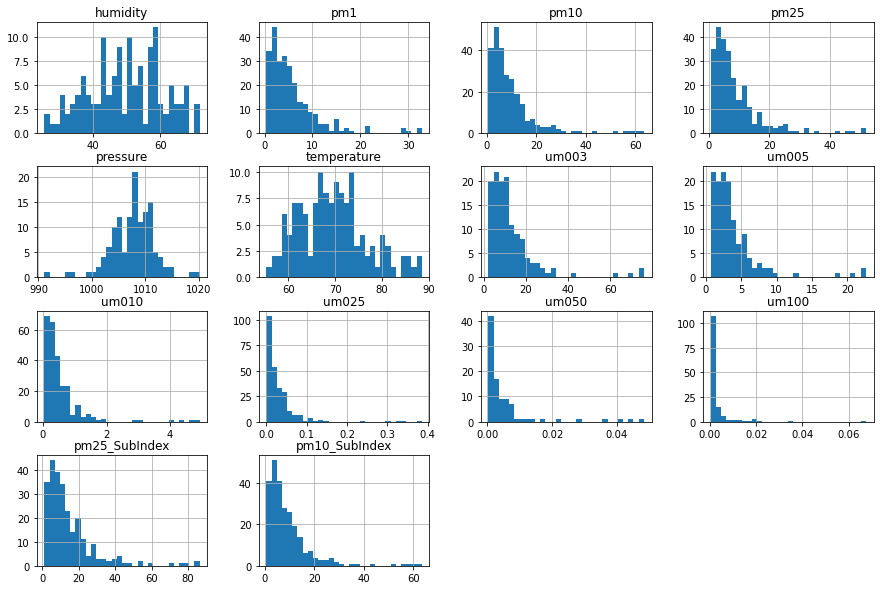

In [28]:
# Histogram of the data
df_mean_day[[i for i in df_mean_day.columns if i not in ["AQI_bucket_calculated","AQI_calculated"]]].hist(bins=30, figsize=(15, 10))
plt.show()

# Model

In [29]:
# Data as input for the model (Time + AQI)
arima_df = df_mean_day[['date.local','AQI_calculated']]
arima_df.head()

parameter,date.local,AQI_calculated
0,2022-11-20,16.0
1,2022-11-21,53.0
2,2022-11-22,16.0
3,2022-11-23,10.0
4,2022-11-24,7.0


In [30]:
# Data on a daily basis
ts = arima_df.groupby(pd.PeriodIndex(arima_df['date.local'], freq="D"))['AQI_calculated'].mean()
ts

date.local
2022-11-20    16.0
2022-11-21    53.0
2022-11-22    16.0
2022-11-23    10.0
2022-11-24     7.0
2022-11-25    11.0
2022-11-26    20.0
2022-11-27     5.0
2022-11-28     9.0
2022-11-29     4.0
2022-11-30    16.0
2022-12-01    10.0
2022-12-02    10.0
2022-12-03    21.0
2022-12-04    29.0
2022-12-05    41.0
2022-12-06    54.0
2022-12-07    20.0
2022-12-08    19.0
2022-12-09    13.0
2022-12-10     1.0
2022-12-11    15.0
2022-12-12    14.0
2022-12-13    16.0
2022-12-15    25.0
2022-12-16    36.0
2022-12-17    44.0
2022-12-18     7.0
2022-12-19     7.0
2022-12-20     9.0
2022-12-21     5.0
2022-12-23    27.0
2022-12-24    12.0
2022-12-25    12.0
2022-12-26     4.0
2022-12-27     2.0
2022-12-28     9.0
2022-12-29     3.0
2022-12-30     7.0
2022-12-31    10.0
2023-01-01    17.0
2023-01-02     4.0
2023-01-03    11.0
2023-01-04     7.0
2023-01-05     2.0
2023-01-06     5.0
2023-01-07     6.0
2023-01-08     2.0
2023-01-09     3.0
2023-01-10     5.0
2023-01-11     3.0
2023-01-15    12.0
2

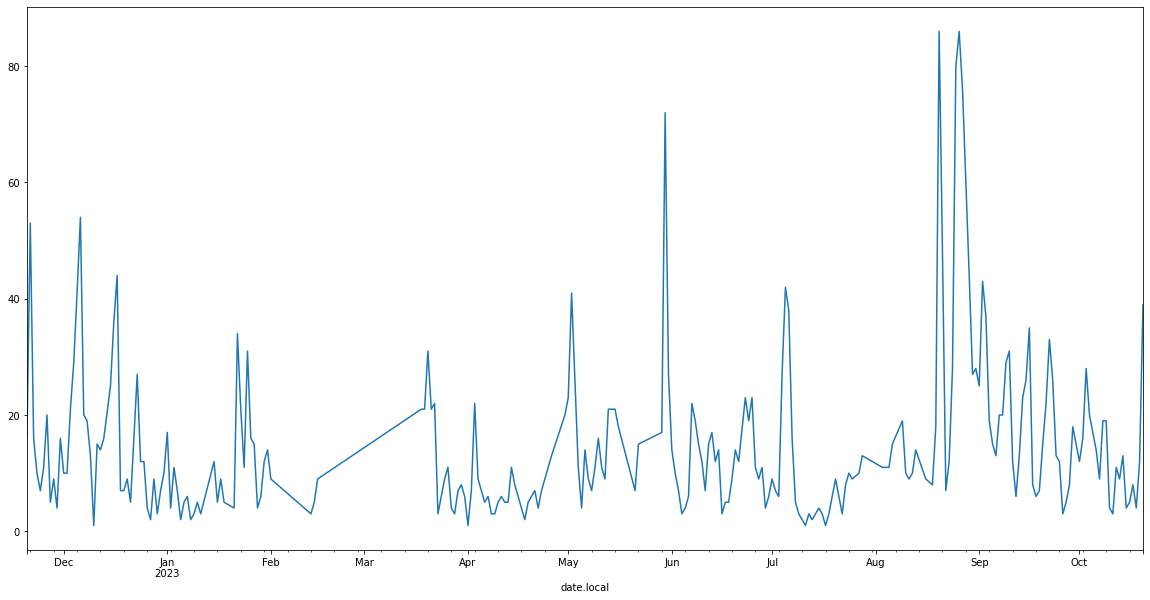

In [31]:
# Time series for AQI
plt.figure(figsize = (20,10))
ts.plot()
plt.show()

In [32]:
# Check for stationarity. If p-value > 0.05 -> calculate the first-order differencing
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.296033
p-value: 0.000451


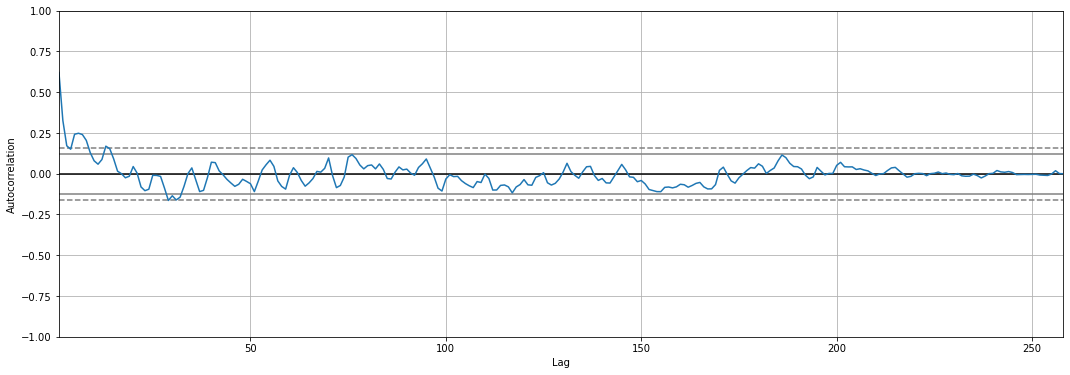

In [33]:
# Autocorrelation plot for estimation model parameters
plt.figure(figsize = (18,6))
autocorrelation_plot(ts)
#plt.xlim(0, 50)
plt.show()

                               SARIMAX Results                                
Dep. Variable:         AQI_calculated   No. Observations:                  258
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -981.319
Date:                Fri, 20 Oct 2023   AIC                           1974.637
Time:                        13:30:16   BIC                           1995.932
Sample:                    11-20-2022   HQIC                          1983.201
                         - 10-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2490      0.042     -5.994      0.000      -0.330      -0.168
ar.L2         -0.3096      0.052     -5.915      0.000      -0.412      -0.207
ar.L3         -0.3054      0.066     -4.608      0.0

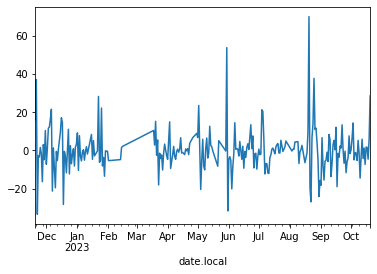

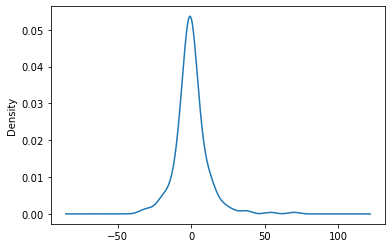

count    258.000000
mean       0.095150
std       11.125671
min      -33.455299
25%       -4.799116
50%       -0.515123
75%        3.615094
max       69.910479
dtype: float64


In [34]:
# Model for time series forecasting: ARIMA (AutoRegressive Integrated Moving Average)

# fit model
model = ARIMA(ts, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = (model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

predicted=5.083493, expected=3.000000
predicted=2.994894, expected=4.000000
predicted=-2.435021, expected=3.000000
predicted=-6.640468, expected=1.000000
predicted=-6.139690, expected=3.000000
predicted=0.557050, expected=6.000000
predicted=5.050791, expected=9.000000
predicted=8.130588, expected=6.000000
predicted=6.498791, expected=3.000000
predicted=4.002325, expected=8.000000
predicted=7.641154, expected=10.000000
predicted=10.524837, expected=9.000000
predicted=9.241848, expected=10.000000
predicted=9.731862, expected=13.000000
predicted=13.805837, expected=11.000000
predicted=12.619517, expected=11.000000
predicted=12.155816, expected=11.000000
predicted=11.445472, expected=15.000000
predicted=14.747334, expected=19.000000
predicted=19.267999, expected=10.000000
predicted=13.206036, expected=9.000000
predicted=9.957831, expected=10.000000
predicted=11.012699, expected=14.000000
predicted=15.053215, expected=9.000000
predicted=9.149579, expected=8.000000
predicted=8.659675, expect

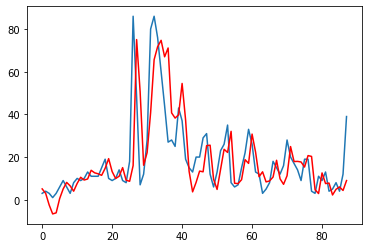

In [35]:
# Training the model

# split into train and test sets
X = ts
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
 model = ARIMA(history, order=(10,2,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
#rmse = sqrt(mean_squared_error(test, predictions))
#print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test.values)
plt.plot(predictions, color='red')
plt.show()

In [36]:
arima_df.dtypes

parameter
date.local         object
AQI_calculated    float64
dtype: object

In [37]:
# Convert from object to datetime
arima_df['date.local'] = pd.to_datetime(arima_df['date.local'])
arima_df.dtypes

C:\Users\lokadmin\AppData\Local\Temp\ipykernel_10296\4190824175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arima_df['date.local'] = pd.to_datetime(arima_df['date.local'])


parameter
date.local        datetime64[ns]
AQI_calculated           float64
dtype: object

In [38]:
# Make future predictions
forecast_periods = 12  # Adjust this value based on how far into the future you want to forecast
forecast = model_fit.forecast(steps=forecast_periods)

# Create a date range for future predictions
last_date = arima_df['date.local'].iloc[-2]
date_range = pd.date_range(start=last_date, periods=forecast_periods+1, closed='right')

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Date': date_range, 'Forecast_AQI': forecast})

C:\Users\lokadmin\AppData\Local\Temp\ipykernel_10296\2460437273.py:7: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  date_range = pd.date_range(start=last_date, periods=forecast_periods+1, closed='right')


In [39]:
forecast_df.dtypes

Date            datetime64[ns]
Forecast_AQI           float64
dtype: object

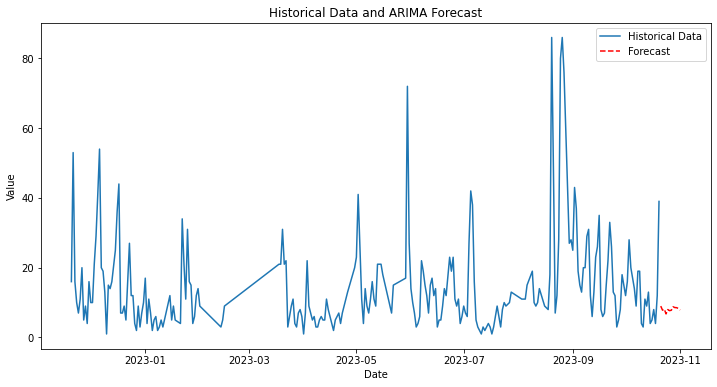

In [40]:
# Visualize the historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(arima_df['date.local'], arima_df['AQI_calculated'], label='Historical Data')
plt.plot(forecast_df['Date'], forecast_df['Forecast_AQI'], label='Forecast', linestyle='--', color='red')
plt.title('Historical Data and ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [41]:
# Forecast
forecast_df["AQI_bucket_forecast"] = forecast_df["Forecast_AQI"].apply(lambda x: get_AQI_bucket(x))
forecast_df

,Date,Forecast_AQI,AQI_bucket_forecast
0,2023-10-21,8.988120,Good
1,2023-10-22,7.817595,Good
2,2023-10-23,8.143389,Good
3,2023-10-24,6.755871,Good
4,2023-10-25,7.992982,Good
5,2023-10-26,7.685100,Good
6,2023-10-27,7.801785,Good
7,2023-10-28,8.791863,Good
8,2023-10-29,8.572302,Good
9,2023-10-30,8.540251,Good
